Hello and welcome into my chaotic workflow into 0.99 accuracy, hope you enjoy the stay

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # the minimum
import csv

In [2]:
# import lux
import texthero # we'll play with those later

ModuleNotFoundError: No module named 'gensim.sklearn_api'

In [ ]:
pathDataSet = "spam.csv" # absolute paths are evil
df = pd.read_csv(pathDataSet) 
#hum parser is confused by the file, i'll try replacing commas with semicolons

 we'll need to replace only the first occurence of a comma

In [ ]:
with open("spam.csv", 'r') as f:
    with open("spam2.csv", 'w') as t:
        for line in f:
            new_line = line.replace(",",";",1) #Python sure is handy 
            t.write(new_line) 

In [3]:
pathDataSet2 = "./Data/spam.csv"
df = pd.read_csv(pathDataSet2,delimiter=",",error_bad_lines=False,header=None,
                 names=["CLASS", "CONTENT"]) 
# Still not good, we have some lines with encoding errors, we may have to forfeit them...

Me looking at the csv file


![me_RightNow](https://pbs.twimg.com/media/ExCcte2WQAYlX7e?format=jpg)


file is 9654 lines long

In [4]:
originalLength = 9654
print(df.shape[0]/originalLength) # how much of the original file have we retained

1.0


well, i guess that's acceptable, i'll think about a solution for those lines later on if i can

##i just realized that forcing the column names would fix all my issues, i'll let the above cells for the sake of my thought process but in normal conditions i would've shamefully deleted them...
well let's get to actual work

In [4]:
df["CONTENT"] = df["CONTENT"].astype(str)
df = df.replace({"CLASS": {"spam":1,"not_spam":0}}) # working with binary looks better

In [5]:
df

,CLASS,CONTENT
0,1,FREE for 1st week! No1 Nokia tone 4 ur mobile ...
1,0,Purity of friendship between two is not about ...
2,1,PRIVATE! Your 2003 Account Statement for shows...
3,1,Goal! Arsenal 4 (Henry
4,0,Also track down any lighters you can find
...,...,...
9649,0,Yar... I tot u knew dis would happen long ago ...
9650,0,That's ok. I popped in to ask bout something a...
9651,1,08714712388 between 10am-7pm Cost 10p
9652,1,Dear Matthew please call 09063440451 from a la...


In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=57) 
df_test

,CLASS,CONTENT
8860,1,Want explicit SEX in 30 secs? Ring 02073162414...
6471,1,SMS SERVICES. for your inclusive text credits
3852,0,Okies... I'll go yan jiu too... We can skip ar...
8025,1,44 7732584351
4354,1,Please call our customer service representativ...
...,...,...
2401,0,idc get over here
9013,1,Mobile Club: Choose any of the top quality ite...
6730,0,Nice.nice.how is it working?
4609,0,I'm very happy for you babe ! Woo hoo party on...


let's first make a bag of words to see how far it will take us

In [21]:
y_train = df_train['CLASS'].values
y_test = df_test['CLASS'].values

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(list(df_train['CONTENT'].values)).todense() 
classifier = LogisticRegression().fit(X_train,y_train)

In [23]:
X_test = vectorizer.transform(list(df_test['CONTENT'].values)).todense()
y_pred = classifier.predict(X_test)

In [24]:
print('Accuracy : %s' % np.mean(y_pred == y_test))

Accuracy : 0.9849818746763335


this kind of accuracy is suspicious, i think i might have forgotten something important let's look at the confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[959  12]
 [ 17 943]]


let's look at our false positives and false negatives

In [10]:
false_negatives = [list(df_test['CONTENT'])[i] for i in range(y_pred.shape[0]) if y_test[i] == 1 and y_pred[i] ==0]
false_positives = [list(df_test['CONTENT'])[i] for i in range(y_pred.shape[0]) if y_test[i] == 0 and y_pred[i] ==1]
false_negatives

["Oh my god! I've found your number again! I'm so glad",
 "Oh my god! I've found your number again! I'm so glad",
 '2/2 146tf150p',
 "Oh my god! I've found your number again! I'm so glad",
 "If you don't",
 'Hi',
 'Free msg. Sorry',
 'Hi',
 'Free msg. Sorry',
 "If you don't",
 'Twinks',
 'Free msg. Sorry',
 'Twinks',
 'Hi',
 'Hi',
 '2/2 146tf150p',
 '2/2 146tf150p']

From what i see, i have either weird messages that probably need manual flagging, or messages containing weird codes, i could probably add a number of numbers feature and a bad topic one 


In [18]:
def count_nb_digits(text):
    return(len([x for x in text if x.isdigit()]))

In [13]:
def is_bad_topic(text):
    lowertext = text.lower()
    badwords = ['bad topics', 'i actually didnt find any bad recurring topics in my false positives/negatives', 'ill put the function in any way']
    isbad = 0
    for word in badwords:
        if word in lowertext:
            isbad+=1
    return isbad
    

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
class CustomVectorizer():
    #we'll decorate our vectorizer to add our features
    vectorizer = CountVectorizer()    
    treelocal = DecisionTreeClassifier(max_depth=17)
    
    def fit(self, df):
        self.vectorizer.fit(list(df['CONTENT'].values))
        y = df['CLASS'].values
        X_train = self.vectorizer.transform(list(df['CONTENT'].values)).todense()
        self.treelocal.fit(X_train,y)
        return self
        
    def transform(self,df):
        X_from_text = self.vectorizer.transform(list(df['CONTENT'].values)).todense()
        dffromText = pd.DataFrame(X_from_text)
        df['nb_digits'] = df['CONTENT'].apply(count_nb_digits)
        # df['is_bad'] = df['CONTENT'].apply(is_bad_topic)
        df = df.reset_index()
        
        dffromText['nbdigits'] = df['nb_digits']
        # dffromText['is_bad'] = df['is_bad']
        Xfinal = dffromText.values
        return Xfinal
    
    def transform_text(self,text):
        X_from_text = self.vectorizer.transform([text]).todense()
        #let's remove some columns
        dffromText = pd.DataFrame(X_from_text)
        coltodrop = []
        for index, item in enumerate(list(self.treelocal.feature_importances_)):
            if float(item) == 0.:
                coltodrop.append(index)
#        dffromText = dffromText.drop(coltodrop, axis=1)
        #let's add new features
        df = pd.DataFrame(X_from_text)
        df['CONTENT'] = text
        df['nb_digits'] = df['CONTENT'].apply(count_nb_digits)
        # df['is_bad'] = df['CONTENT'].apply(is_bad_topic)
        df = df.reset_index()
        
        dffromText['nbdigits'] = df['nb_digits']
        # dffromText['is_bad'] = df['is_bad']
        Xfinal = dffromText.values
        return Xfinal
        


In [25]:
vectorizer = CustomVectorizer()


X_train = vectorizer.fit(df_train).transform(df_train)

X_test = vectorizer.transform(df_test)
clf = LogisticRegression(C = 1).fit(X_train, y_train)

<ipython-input-16-a6dfc90bfc93>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nb_digits'] = df['CONTENT'].apply(count_nb_digits)


In [26]:
y_pred = clf.predict(X_test)

print('Accuracy : %s' % np.mean(y_pred == y_test))

Accuracy : 0.9891248058001035


I got some minor improvement but nothing really noticeable since we're already so close to 98%, i'll try to put all of this in a class to make it easier to use.

In [27]:
class CustomModel():
    _innerModel = LogisticRegression(C = 1)
    _vectorizer = CustomVectorizer()
    
    def fit(self, df):
        y = df['CLASS'].values
        self._vectorizer.fit(df)
        X = self._vectorizer.transform(df)
        self._innerModel.fit(X,y)
        return self
        
    
    def predict(self,df):
        X = self._vectorizer.transform(df)
        return self._innerModel.predict(X)
    
    def predict_text(self,text):
        X = self._vectorizer.transform_text(text)
        y = self._innerModel.predict(X)
        if int(y) == 1:
            return 'SPAM !!!'
        else:
            return 'ok'

In [28]:

clf = CustomModel().fit(df_train)
y_pred = clf.predict(df_test)


print('Accuracy : %s' % np.mean(y_pred == y_test))

<ipython-input-16-a6dfc90bfc93>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nb_digits'] = df['CONTENT'].apply(count_nb_digits)
Accuracy : 0.9891248058001035
<ipython-input-16-a6dfc90bfc93>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nb_digits'] = df['CONTENT'].apply(count_nb_digits)


Time is running and i don't have much left before 23:59 i'll settle for this model 

let's try with something else, i'll look up some spam datasets on kaggle and we'll see how my classifier performs 

i used this one : https://www.kaggle.com/uciml/sms-spam-collection-dataset/

In [34]:
pathKaggleSet = "./Data/spamKaggle.csv"
dfKaggle = pd.read_csv(pathKaggleSet)
dfKaggle = dfKaggle[['v1','v2']] #Only intereset in the first columns
dfKaggle = dfKaggle.replace({"v1": {"spam":1,"ham":0}})
dfKaggle= dfKaggle.rename(columns={'v1': 'CLASS', 'v2': 'CONTENT'})
y_testKaggle = dfKaggle['CLASS'].values
y_pred = clf.predict(dfKaggle)
# x_testKaggle = vectorizer.transform(list(dfKaggle['CONTENT'].values)).todense()


In [36]:
# predKaggle = classifier.predict(x_testKaggle)
print('Accuracy : %s' % np.mean(y_pred == y_testKaggle)) #we got some improvement i guess

Accuracy : 0.9960516870064609


In [15]:
cm = confusion_matrix(y_testKaggle, predKaggle)
print(cm)


[[4795   30]
 [   3  744]]


In [16]:
true_spams = [list(dfKaggle['CONTENT'])[i] for i in range(predKaggle.shape[0]) if y_testKaggle[i] == 1 and predKaggle[i] ==0]
false_spams = [list(dfKaggle['CONTENT'])[i] for i in range(predKaggle.shape[0]) if y_testKaggle[i] == 0 and predKaggle[i] ==1]

as weird as it seems it looks like the model is *this* accurate but i'm sure i forgot something. it happened once to classmates where they forgot to drop the class table from the test set but i made sure to only pass the column content so it couldn't be this. 

i'll try a youtube spam dataset this time. from here : https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection

In [17]:
path_psy = 'Youtube01-Psy.csv'
path_perry = 'Youtube02-KatyPerry.csv'
path_LMFAO = 'Youtube03-LMFAO.csv'
path_eminem = 'Youtube04-Eminem.csv'
path_shakira = 'Youtube05-Shakira.csv'

df_psy = pd.read_csv(path_psy)
df_perry = pd.read_csv(path_perry)
df_LMFAO = pd.read_csv(path_LMFAO)
df_eminem = pd.read_csv(path_eminem)
df_shakira = pd.read_csv(path_shakira)

In [18]:
bigDf = pd.concat([df_psy,df_perry,df_LMFAO,df_eminem,df_shakira])
bigDf

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...,...,...,...
365,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0
366,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0
367,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,0
368,_2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0


In [19]:
bigDf.drop(['COMMENT_ID', 'AUTHOR','DATE'],axis=1)



,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...
365,I love this song because we sing it at Camp al...,0
366,I love this song for two reasons: 1.it is abou...,0
367,wow,0
368,Shakira u are so wiredo,0


I should maybe factorize the prediction part into a function

In [20]:
y_testBig = bigDf['CLASS'].values
x_testBig = vectorizer.transform(list(bigDf['CONTENT'].values)).todense() 

In [21]:
pred = classifier.predict(x_testBig)
print('Accuracy : %s' % np.mean(pred == y_testBig))  

Accuracy : 0.5393660531697342


alright so we got less than 0.99 which is good news i guess ? means our model and way of training it isn't that bad, this result is most likely because youtube spam and sms spams are a lil bit too different

# METRICS

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_predict

In [23]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[959  12]
 [ 17 943]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       971
           1       0.99      0.98      0.98       960

    accuracy                           0.98      1931
   macro avg       0.99      0.98      0.98      1931
weighted avg       0.98      0.98      0.98      1931

0.9849818746763335


In [24]:
X = vectorizer.fit_transform(list(df['CONTENT'].values)).todense()
len(X)

9654

In [25]:

predicted = cross_val_predict(classifier, X, df['CLASS'] , cv=4) #4 fold CV

print (metrics.accuracy_score(df['CLASS'], predicted))
print (metrics.classification_report(df['CLASS'], predicted))

0.9897451833436918
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4827
           1       0.99      0.99      0.99      4827

    accuracy                           0.99      9654
   macro avg       0.99      0.99      0.99      9654
weighted avg       0.99      0.99      0.99      9654



As we can tell from the classification report the model is really really accurate, but i do believe it's caused by the dataset

let's compute the ROC curve, i've never done it but it looks interesting and statiscally pertinent

In [26]:
y_score = classifier.predict_proba(X_test)
y_score = np.array(y_score)

In [27]:
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, neg_label=0, pos_label=1, classes=[0,1])
y_test_bin = np.hstack((1 - y_test_bin, y_test_bin)) # had to google that bit of code because binarize gives weird results with only 2 classes

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in [0,1]:
    # collect labels and scores for the current index
    labels = y_test_bin[:, i]
    scores = y_score[:, i]
    
    # calculates FPR and TPR for a number of thresholds
    fpr[i], tpr[i], thresholds = roc_curve(labels, scores)
    
    # given points on a curve, this calculates the area under it
    roc_auc[i] = auc(fpr[i], tpr[i])

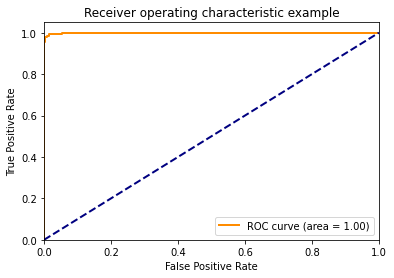

In [49]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

this kind of accuracy is very very very very suspicious but i have no idea what's causing it, i would gladly get some insight from you guys at owlint. it's only friday and i'll bang my head against the wall until i get an explanation.

Anyhow, this graph shows us that we have very little false positive rate, and that it remains constant no matter the thresholds, the default one being 50%

In [50]:
df['CLASS'].value_counts() 

0    4827
1    4827
Name: CLASS, dtype: int64

Kinda late to check on dataset balance but...it's perfectly balanced...as all things should be

This makes ROC & AUC a bit more legitimate as they tend to underperform when datasets are unbalanced.

i'll now try to factor all of this in a .py file and turn all of that into a nice API, see you on the other side !

if i have enough time i'll come back to the model and try to think that it wasn't this good and try to perfect it.


In [10]:
import pickle
pickle.dump(classifier, open('./models/final_prediction.pickle', 'wb'))
pickle.dump(vectorizer, open('./models/final_prediction_vectorizer.pickle', 'wb')) 
# my baby is ready to leave the household